# LSTM (Long Short Term Memory)

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](./RNN-unrolled.png)

Pros:
- Really powerful pattern recognition system for time series

Cons:
- Cannot deal with missing time steps.
- Time steps must be discretised and not continuous.

![trump](./images/trump.jpg)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
def chr2val(ch):
    ch = ch.lower()
    if ch.isalpha():
        return 1 + (ord(ch) - ord('a'))
    else:
        return 0
    
def val2chr(v):
    if v == 0:
        return ' '
    else:
        return chr(ord('a') + v - 1)

In [3]:
df = pd.read_csv('trump.csv')
df = df[df.is_retweet=='false']
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.lower()
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,08-07-2017 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,08-07-2017 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,08-07-2017 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday💜i thank all the brave men a...,08-07-2017 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,08-07-2017 12:01:20,59253,false,8.945289e+17


In [4]:
df.shape

(23938, 6)

Remove emojis, flags etc from tweets. Also notice how I have used `[::-1]` to indicate that I want the tweets in chrnological order.

In [5]:
# remove emojis and flags
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
trump_tweets = [emoji_pattern.sub(r' ', text) for text in df.text.values[::-1]]
trump_tweets[:5]

['be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight!',
 'donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion!',
 'donald trump reads top ten financial tips on late show with david letterman:  - very funny!',
 'new blog post: celebrity apprentice finale and lessons learned along the way: ',
 'my persona will never be that of a wallflower - i’d rather build walls than cling to them --donald j. trump']

Create a dictionary to convert letters to numbers and vice versa.

In [6]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [7]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

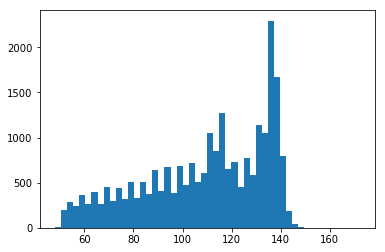

In [8]:
plt.hist([len(t) for t in trump_tweets],50)
plt.show()

In [9]:
# Concatenate all the tweets
int_text = []
for t in text_num:
    int_text += t

len_vocab = len(char2int)
sentence_len = 40
# n_chars = len(text_num)//sentence_len*sentence_len
num_chunks = len(text_num)-sentence_len

def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: Batches as a Numpy array
    """
    
    slice_size = batch_size * seq_length
    n_batches = len(int_text) // slice_size
    x = int_text[: n_batches*slice_size]
    y = int_text[1: n_batches*slice_size + 1]

    x = np.split(np.reshape(x,(batch_size,-1)),n_batches,1)
    y = np.split(np.reshape(y,(batch_size,-1)),n_batches,1)
    
    x = np.vstack(x)
    y = np.vstack(y)
    y = y.reshape(y.shape+(1,))
    return x, y

batch_size = 128
x, y = get_batches(int_text, batch_size, sentence_len)

Notice what the `get_batches` function looks like.

In [13]:
get_batches(np.arange(20), 2,4)

(array([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11],
        [ 4,  5,  6,  7],
        [12, 13, 14, 15]]), array([[ 1,  2,  3,  4],
        [ 9, 10, 11, 12],
        [ 5,  6,  7,  8],
        [13, 14, 15, 16]]))

## Many to Many LSTM

In [14]:
model = Sequential()
# TODO: 
# 1. Add an embedding layer
# 2. Add a LSTM layer, set `return_sequences=True` and stateful = True
# 3. Add another LSTM layer, set `return_sequences=True` and stateful = True
# 4. Add a `TimeDistributed(Dense(...)) layer (connected to how many outputs? What is the activation?)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (128, None, 64)           8512      
_________________________________________________________________
lstm_1 (LSTM)                (128, None, 64)           33024     
_________________________________________________________________
lstm_2 (LSTM)                (128, None, 64)           33024     
_________________________________________________________________
time_distributed_1 (TimeDist (128, None, 133)          8645      
Total params: 83,205.0
Trainable params: 83,205
Non-trainable params: 0.0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape `(1, sequence_len, len(char2int))` where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, `y`. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution `p[0][-1]`.

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory. 

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

### Stateful training:

What happens when `stateful=True` is that the last cell memory state computed at the i-th example in the n-th batch gets passed on to i-th sample in the n+1-th batch. This is one way of _seeing_ patterns beyond the sentence length specified. Which in this case is 40.

#### Note
1. Really important that when I `fit` the model I set `shuffle=False` when training stateful models.
2. I need to copy the weights to a non-stateful model because the original only takes `batch_size` inputs at a time. Whereas, I only want to predict one character at a time.

In [17]:
model2 = Sequential()
# TODO
# Create the same model architecture as above, however, no need to compile or create the summary

In [72]:
n_epochs = 50
for i in range(n_epochs+1):
    if i%5==0:
        sentence = []
        letter = [char2int['<GO>']] #choose a random letter
        for i in range(100):
            sentence.append(int2char[letter[-1]])
            model2.set_weights(model.get_weights())
            p = model2.predict(np.array(letter)[None,:])
            letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
        print(''.join(sentence))
        print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=batch_size, epochs=1, shuffle=False)
        model.reset_states()

<GO>teradisid @realdonaldtrump i!.<END><GO>shaoning!<END><GO>dong drindter town be pabitate.<END><GO>americas you honely thi
Epoch 1/1
66560/66560 [==============================] - 90s - loss: 1.8014    
Epoch 1/1
66560/66560 [==============================] - 107s - loss: 1.7881   
Epoch 1/1
66560/66560 [==============================] - 109s - loss: 1.7763   
Epoch 1/1
66560/66560 [==============================] - 106s - loss: 1.7657   
Epoch 1/1
66560/66560 [==============================] - 105s - loss: 1.7560   - ETA: 3s
<GO>ohamerible anergigh manigion (316      9 thinks? fambew losonised made up plcind.  the beaded?thing
Epoch 1/1
66560/66560 [==============================] - 107s - loss: 1.7471   - ETA: 1s - loss
Epoch 1/1
66560/66560 [==============================] - 105s - loss: 1.7389   
Epoch 1/1
66560/66560 [==============================] - 102s - loss: 1.7314   
Epoch 1/1
66560/66560 [==============================] - 98s - loss: 1.7241    
Epoch 1/1
66560/66560 [===

KeyboardInterrupt: 

In [138]:
with open('model_struct.json','w') as f:
    f.write(model.to_json())
model.save_weights('model_weights.h5')
model.save('model.h5')

In [34]:
# if not 'model' in vars():
# #     model = load_model('model.h5') # This doesn't seem to work for some odd reason
#     with open('model_struct.json','r') as f:
#         model = model_from_json(f.read())
#     model.load_weights('model_weights.h5')

In [19]:
model = Sequential()
model.add(Embedding(len_vocab, 64)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True)) # , stateful=True
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()
model.load_weights('model_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          8512      
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 133)         8645      
Total params: 50,181.0
Trainable params: 50,181
Non-trainable params: 0.0
_________________________________________________________________


In [20]:
for j in range(10):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>❤ q✨1iqáiq​it iw6♥❤/wi☁6 iq✨i‏☁q✨/d‼i~wqá6w☁(i​☁´t6i​/ q✨1i ´♥iá/❤\iw♥✨☝iq✨​áw♥‏áq´✨i"´wiá☁q​iá´i16~(i/✨☝i✨´ái☺❤/♥✨i☺❤/✨​i/☝☉di16w/❤​i"´☝ig✨61w6ái‏/✨
<GO>it/\6i ´♥i☁6iá☁6iq✨á6w6☝=​i/✨☝i~q❤❤it/‏\/✨☝♡{i~q❤w6​i/✨☝i/i☺6w​´✨i☁/☉6i♥✨"áiáqt6☝☞i‏w´´\6w(ii❌áw♥t☺‏´❤6‏á (i‼☁/☺☺6✨​iq​i/9​´w iá´i‏w6/á6i❤´´\​i☝´{igw
<GO>~☁ i☝´✨=ái96"´w6iá☁6i♥☺iá´i16ááq✨1i/✨‏t​‏♥á(igá6☉6✨☝"´~á❤☝1☁á​iq​iq✨i/‏‏6​​i~☁ i‏☁/❤❤6/á​i‏/t☺/q1✨=ái☺´❤❤(i/i1´☉6w✨61/ i​☁♥ái´♥wi☺´❤qá´✨i~3)♥✨☝❤i~☁ i
<GO>g/á‏❤♥9​​(i96‏´♥w✨6wi‏´ttiá´i»☺6ww (i/​i‏6áá6w(i/i☝/☉6☝i9w/q✨​á6wi ´♥i♥✨qá (i❌1w6✨✨á6w´​tq​áq´✨i~6/☺6‏´✨‏6☝i​/q☝i ´♥iá☁/✨iá☁6=​i✨/áq´✨​(i​/ ​iá´iá☁6i
<GO>gá☁6á6wt♥☺6iq✨i6☝q✨6​(iá☁6 i/✨☝i❤´´\(i‏❤/✨it/☝6i/✨ ´✨6i«-s-i6%☺/✨☝ i"´wi´♥wi❌´♥á/1/✨i☁/✨☝​i"´wi/i❤´✨1(i‏´♥✨áw (igá´tt6☝/16(i6/​ #i/✨i6%6‏♥áq☉6i☺❤/‏6​


KeyboardInterrupt: 